In [2]:
import torch
from pathlib import Path
import numpy as np
from scipy.sparse import coo_matrix,csr_matrix,diags,eye

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device) # 查看计算资源

# 数据路径
path = Path('./data/cora')

cuda


In [3]:
# 读取特征数据
paper_features_label = np.genfromtxt(path/'cora.content',dtype=np.str_) 

# 取出数据集中的第一列:论文ID
papers = paper_features_label[:,0].astype(np.int32)
# 论文重新编号，并将其映射到论文ID中，实现论文的统一管理
paper2idx = {k:v for v,k in enumerate(papers)}

# 将数据中间部分的字标签取出，转化成矩阵
features = csr_matrix(paper_features_label[:,1:-1],dtype=np.float32)

# 将数据的最后一项的文章分类属性取出，转化为分类的索引
labels = paper_features_label[:,-1]
lbl2idx = {k:v for v,k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]

In [4]:
# 读取论文关系数据
edges = np.genfromtxt(path/'cora.cites',dtype=np.int32) # 将数据集中论文的引用关系以数据的形式读入

# 转化为新编号节点间的关系：将数据集中论文ID表示的关系转化为重新编号后的关系
edges = np.asarray([paper2idx[e] for e in edges.flatten()],np.int32).reshape(edges.shape)

# 计算邻接矩阵，行与列都是论文个数：由论文引用关系所表示的图结构生成邻接矩阵。
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),shape=(len(labels), len(labels)), dtype=np.float32)
# 生成无向图对称矩阵：将有向图的邻接矩阵转化为无向图的邻接矩阵。Tip：转化为无向图的原因：主要用于对论文的分类，论文的引用关系主要提供单个特征之间的关联，故更看重是不是有关系，所以无向图即可。
adj_long = adj.multiply(adj.T < adj)
adj = adj_long + adj_long.T

In [5]:
# 归一化处理

# 定义函数，对矩阵的数据进行归一化处理
def normalize(mx): 
    rowsum = np.array(mx.sum(1)) 
    r_inv = (rowsum ** -1).flatten() 
    r_inv[np.isinf(r_inv)] = 0.0 
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx) 
    return mx

# 对features矩阵进行归一化处理（每行总和为1）
features = normalize(features) 
# 对邻接矩阵的对角线添1，再对其进行归一化处理
adj = normalize(adj + eye(adj.shape[0])) 

In [6]:
# 将数据转化为张量，并分配运算资源
adj = torch.FloatTensor(adj.todense()) # 节点间关系 todense()方法将其转换为矩阵。
features = torch.FloatTensor(features.todense()) # 节点自身的特征
labels = torch.LongTensor(labels) # 对每个节点的分类标签
 
# 划分数据集
n_train = 1500 # 训练数据集大小
n_val = 500 # 验证数据集大小
n_test = len(features) - n_train - n_val # 测试数据集大小
np.random.seed(34)
idxs = np.random.permutation(len(features)) # 将原有的索引打乱顺序
 
# 计算每个数据集的索引
idx_train = torch.LongTensor(idxs[:n_train]) # 根据指定训练数据集的大小并划分出其对应的训练数据集索引
idx_val = torch.LongTensor(idxs[n_train:n_train+n_val])# 根据指定验证数据集的大小并划分出其对应的验证数据集索引
idx_test = torch.LongTensor(idxs[n_train+n_val:])# 根据指定测试数据集的大小并划分出其对应的测试数据集索引
 
# 分配运算资源
adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [7]:
# 定义函数计算准确率
def accuracy(output,y): 
    return (output.argmax(1) == y).type(torch.float32).mean().item()
 
# 定义函数来实现模型的训练过程。与深度学习任务不同，图卷积在训练时需要传入样本间的关系数据。
# 因为该关系数据是与节点数相等的方阵，所以传入的样本数也要与节点数相同，在计算loss值时，可以通过索引从总的运算结果中取出训练集的结果。
# 定义函数来训练模型 Tip：在图卷积任务中，无论是用模型进行预测还是训练，都需要将全部的图结构方阵输入
def step():
    model.train()
    optimizer.zero_grad()
    output = model(features,adj) # 将全部数据载入模型，只用训练数据计算损失
    loss = F.cross_entropy(output[idx_train],labels[idx_train])
    acc = accuracy(output[idx_train],labels[idx_train]) # 计算准确率
    loss.backward()
    optimizer.step()
    return loss.item(),acc
 
 # 定义函数来评估模型
def evaluate(idx): 
    model.eval()
    output = model(features, adj) # 将全部数据载入模型，用指定索引评估模型结果
    loss = F.cross_entropy(output[idx], labels[idx]).item()
    return loss, accuracy(output[idx], labels[idx])

  2%|▏         | 38/2000 [00:00<00:10, 183.42it/s]

     1/2000: train_loss=1.9463, train_acc=0.1060, val_loss=1.9460, val_acc=0.1020


  4%|▍         | 76/2000 [00:00<00:10, 177.51it/s]

    50/2000: train_loss=1.9411, train_acc=0.2193, val_loss=1.9401, val_acc=0.2280


  7%|▋         | 133/2000 [00:00<00:10, 183.09it/s]

   100/2000: train_loss=1.9304, train_acc=0.2773, val_loss=1.9283, val_acc=0.3100


  9%|▊         | 173/2000 [00:00<00:09, 188.41it/s]

   150/2000: train_loss=1.9175, train_acc=0.2887, val_loss=1.9138, val_acc=0.3140


 12%|█▏        | 241/2000 [00:01<00:08, 213.38it/s]

   200/2000: train_loss=1.8979, train_acc=0.2900, val_loss=1.8917, val_acc=0.3140


 14%|█▍        | 285/2000 [00:01<00:08, 212.70it/s]

   250/2000: train_loss=1.8718, train_acc=0.2900, val_loss=1.8614, val_acc=0.3140


 16%|█▋        | 329/2000 [00:01<00:07, 211.00it/s]

   300/2000: train_loss=1.8447, train_acc=0.2900, val_loss=1.8293, val_acc=0.3140


 19%|█▊        | 372/2000 [00:01<00:08, 200.69it/s]

   350/2000: train_loss=1.8158, train_acc=0.2900, val_loss=1.7939, val_acc=0.3140


 21%|██        | 424/2000 [00:02<00:06, 228.14it/s]

   400/2000: train_loss=1.7909, train_acc=0.2900, val_loss=1.7650, val_acc=0.3140


 24%|██▎       | 470/2000 [00:02<00:07, 208.90it/s]

   450/2000: train_loss=1.7655, train_acc=0.2920, val_loss=1.7393, val_acc=0.3140


 27%|██▋       | 534/2000 [00:02<00:07, 194.61it/s]

   500/2000: train_loss=1.7247, train_acc=0.2927, val_loss=1.7000, val_acc=0.3160


 29%|██▊       | 574/2000 [00:02<00:07, 188.61it/s]

   550/2000: train_loss=1.6625, train_acc=0.3193, val_loss=1.6407, val_acc=0.3400


 32%|███▏      | 634/2000 [00:03<00:07, 195.04it/s]

   600/2000: train_loss=1.5821, train_acc=0.3720, val_loss=1.5644, val_acc=0.3880


 34%|███▎      | 674/2000 [00:03<00:07, 188.17it/s]

   650/2000: train_loss=1.4547, train_acc=0.4887, val_loss=1.4446, val_acc=0.5020


 37%|███▋      | 731/2000 [00:03<00:06, 184.03it/s]

   700/2000: train_loss=1.2868, train_acc=0.6067, val_loss=1.2878, val_acc=0.6040


 38%|███▊      | 769/2000 [00:03<00:06, 177.44it/s]

   750/2000: train_loss=1.1123, train_acc=0.6953, val_loss=1.1261, val_acc=0.6820


 41%|████▏     | 827/2000 [00:04<00:06, 184.92it/s]

   800/2000: train_loss=0.9124, train_acc=0.7580, val_loss=0.9423, val_acc=0.7340


 44%|████▍     | 886/2000 [00:04<00:05, 188.15it/s]

   850/2000: train_loss=0.7463, train_acc=0.8147, val_loss=0.7913, val_acc=0.7860


 46%|████▋     | 926/2000 [00:04<00:05, 192.07it/s]

   900/2000: train_loss=0.6350, train_acc=0.8473, val_loss=0.6952, val_acc=0.8220


 49%|████▉     | 986/2000 [00:05<00:05, 194.34it/s]

   950/2000: train_loss=0.5413, train_acc=0.8713, val_loss=0.6204, val_acc=0.8380


 51%|█████▏    | 1027/2000 [00:05<00:04, 198.39it/s]

  1000/2000: train_loss=0.4721, train_acc=0.8840, val_loss=0.5703, val_acc=0.8440


 55%|█████▌    | 1107/2000 [00:05<00:03, 244.49it/s]

  1050/2000: train_loss=0.4261, train_acc=0.8913, val_loss=0.5406, val_acc=0.8480
  1100/2000: train_loss=0.3856, train_acc=0.8987, val_loss=0.5174, val_acc=0.8500


 60%|█████▉    | 1191/2000 [00:05<00:03, 261.29it/s]

  1150/2000: train_loss=0.3544, train_acc=0.9060, val_loss=0.5044, val_acc=0.8540
  1200/2000: train_loss=0.3311, train_acc=0.9093, val_loss=0.4944, val_acc=0.8540


 64%|██████▎   | 1274/2000 [00:06<00:02, 250.31it/s]

  1250/2000: train_loss=0.3096, train_acc=0.9140, val_loss=0.4887, val_acc=0.8580


 66%|██████▋   | 1325/2000 [00:06<00:02, 225.44it/s]

  1300/2000: train_loss=0.2910, train_acc=0.9153, val_loss=0.4854, val_acc=0.8600


 68%|██████▊   | 1370/2000 [00:06<00:02, 210.85it/s]

  1350/2000: train_loss=0.2772, train_acc=0.9173, val_loss=0.4836, val_acc=0.8640


 72%|███████▏  | 1434/2000 [00:07<00:02, 202.41it/s]

  1400/2000: train_loss=0.2624, train_acc=0.9220, val_loss=0.4829, val_acc=0.8680


 74%|███████▍  | 1476/2000 [00:07<00:02, 204.27it/s]

  1450/2000: train_loss=0.2501, train_acc=0.9273, val_loss=0.4858, val_acc=0.8680


 77%|███████▋  | 1542/2000 [00:07<00:02, 210.84it/s]

  1500/2000: train_loss=0.2399, train_acc=0.9287, val_loss=0.4895, val_acc=0.8660


 79%|███████▉  | 1586/2000 [00:07<00:01, 207.80it/s]

  1550/2000: train_loss=0.2295, train_acc=0.9307, val_loss=0.4945, val_acc=0.8680


 81%|████████▏ | 1628/2000 [00:07<00:01, 202.46it/s]

  1600/2000: train_loss=0.2207, train_acc=0.9340, val_loss=0.5015, val_acc=0.8620


 84%|████████▎ | 1671/2000 [00:08<00:01, 200.43it/s]

  1650/2000: train_loss=0.2131, train_acc=0.9353, val_loss=0.5043, val_acc=0.8620


 87%|████████▋ | 1734/2000 [00:08<00:01, 202.65it/s]

  1700/2000: train_loss=0.2054, train_acc=0.9367, val_loss=0.5122, val_acc=0.8580


 90%|████████▉ | 1791/2000 [00:08<00:00, 242.29it/s]

  1750/2000: train_loss=0.1982, train_acc=0.9393, val_loss=0.5191, val_acc=0.8700
  1800/2000: train_loss=0.1925, train_acc=0.9413, val_loss=0.5260, val_acc=0.8660


 94%|█████████▍| 1877/2000 [00:09<00:00, 266.55it/s]

  1850/2000: train_loss=0.1869, train_acc=0.9420, val_loss=0.5298, val_acc=0.8720


 96%|█████████▋| 1929/2000 [00:09<00:00, 228.99it/s]

  1900/2000: train_loss=0.1811, train_acc=0.9460, val_loss=0.5384, val_acc=0.8700


 99%|█████████▉| 1976/2000 [00:09<00:00, 221.57it/s]

  1950/2000: train_loss=0.1767, train_acc=0.9480, val_loss=0.5445, val_acc=0.8720


100%|██████████| 2000/2000 [00:09<00:00, 207.97it/s]


  2000/2000: train_loss=0.1717, train_acc=0.9507, val_loss=0.5528, val_acc=0.8680
Train     : loss=0.1717, accuracy=0.9507
Validation: loss=0.5528, accuracy=0.8680
Test      : loss=0.6939, accuracy=0.8559


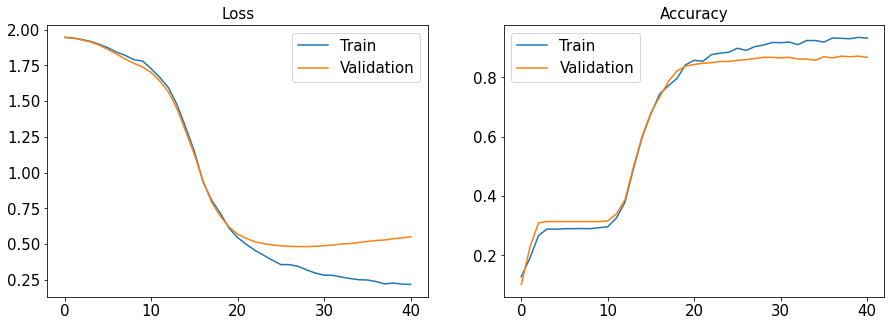

In [16]:
from GCN import *
from tqdm import tqdm
from Ranger import * 
import matplotlib.pyplot as plt
%matplotlib inline

# 分类和关键词数量
n_labels = 7
n_features = features.shape[1] 

model = GCN(n_features, n_labels, hidden=[16, 32, 16]).to(device)
optimizer = Ranger(model.parameters())


# 训练模型
epochs = 2000
print_steps = 50
train_loss, train_acc = [], []
val_loss, val_acc = [], []
for i in tqdm(range(epochs)):
    tl,ta = step()
    train_loss = train_loss + [tl]
    train_acc = train_acc + [ta]
    if (i+1) % print_steps == 0 or i == 0:
        tl,ta = evaluate(idx_train)
        vl,va = evaluate(idx_val)
        val_loss = val_loss + [vl]
        val_acc = val_acc + [va]
        print(f'{i + 1:6d}/{epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}' + f', val_loss={vl:.4f}, val_acc={va:.4f}')
 
# 输出最终结果
final_train, final_val, final_test = evaluate(idx_train), evaluate(idx_val), evaluate(idx_test)
print(f'Train     : loss={final_train[0]:.4f}, accuracy={final_train[1]:.4f}')
print(f'Validation: loss={final_val[0]:.4f}, accuracy={final_val[1]:.4f}')
print(f'Test      : loss={final_test[0]:.4f}, accuracy={final_test[1]:.4f}')
 
# 可视化训练过程
plt.switch_backend('agg')
plt.rc('font',family='Times New Roman', size=15)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')
for ax,t in zip(axes, ['Loss', 'Accuracy']): ax.legend(), ax.set_title(t, size=15)
plt.savefig('result.jpg')
 